In [1]:
%matplotlib inline
import os, pickle, logging, pickle, joblib, sys, warnings
warnings.simplefilter('ignore')
from scipy import stats
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

from sklearn import ensemble, metrics, pipeline, preprocessing, impute, model_selection
from scipy.stats import pearsonr, spearmanr

import shap

font_path = "/home/zhoujb/local/font/Times New Roman.ttf"
mpl.font_manager.fontManager.addfont(font_path)
prop = mpl.font_manager.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

RAW_PATH = "/data2/zhoujb/project/cowpea_project/rawData/"
ML_RAW_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/rawData/"
FS_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/fs_PStarch/"
TEST_RES_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/tesRes/"
FIG_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/figRes/"

In [2]:
feat_col_raw = []
with open(os.path.join(FS_PATH, "cb_rfa_cv_pstarch_rmse")) as f:
    for line in f:
        feat_col_raw.append(line.strip())

feat_col = []
feat_col_map = {}
for item in feat_col_raw:
    feat_col.append(item[4:])
    feat_col_map[item] = item[4:]


raw_data = pd.read_table(os.path.join(ML_RAW_PATH, "raw_data_PStarch.txt"), sep="\t", index_col=0)
raw_data = raw_data.rename(columns=feat_col_map)

target_col = ['HZ-PStarch']
raw_data = raw_data.dropna(subset=target_col)

kf = model_selection.KFold(n_splits=5, shuffle=True,  random_state=0)
y_test_final, y_pred_final = [], []
for i, (train_index, test_index) in enumerate(kf.split(raw_data)):
    data_train = raw_data.iloc[train_index].copy()
    data_test = raw_data.iloc[test_index].copy()

    scale_tool = preprocessing.StandardScaler()
    scale_tool.fit(data_train.loc[:, feat_col])
    data_train.loc[:, feat_col] = scale_tool.transform(data_train.loc[:, feat_col])
    data_test.loc[:, feat_col] = scale_tool.transform(data_test.loc[:, feat_col])

    train_sel = data_train.sample(frac=0.8, random_state=0)
    val_sel = data_train.drop(train_sel.index).copy()

    X_train = train_sel[feat_col].copy()
    y_train = train_sel[target_col].values.ravel()

    X_val = val_sel[feat_col].copy()
    y_val = val_sel[target_col].values.ravel()

    X_test = data_test[feat_col].copy()
    y_test = data_test[target_col].values.ravel()

    if i == 2:
        break

# Initialize CatBoostClassifier
clf_model = cb.CatBoostRegressor(random_state=0, thread_count=4, loss_function='RMSE')
# Fit model
clf_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, plot=False)

y_pred = clf_model.predict(X_test)

#score_pear = pearsonr(y_test, y_pred)[0]
score_spear = spearmanr(y_test, y_pred)[0]
score_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
score_nrmse = score_rmse / np.std(y_test)

score_spear, score_rmse, score_nrmse

(0.7172547929980552, 1.2885169483452632, 0.7486196689161324)

In [3]:
data_scale = raw_data[feat_col].copy()
data_scale.loc[:, feat_col] = scale_tool.transform(data_scale.loc[:, feat_col])

explainer = shap.TreeExplainer(clf_model)
shap_values = explainer(data_scale[feat_col])

In [4]:
detail_info = pd.read_excel(os.path.join(RAW_PATH, "Detail_information_344.xlsx"), index_col="Genotype No.")
detail_info = detail_info.loc[data_scale.index]
detail_info["Type"] = detail_info["Types"].map({'Grain':"G", 'V-landrace':"VL", '-':"NA", 'V-cultivar':"VC"})

Source = detail_info.loc[data_scale.index]["Type"].to_list()

target_df = raw_data[target_col]
target_df = pd.concat([target_df, detail_info[["Type"]]], axis=1)
target_df = target_df.reset_index()

In [5]:
target_df[target_df["index"]=="D554"]

,index,HZ-PStarch,Type
294,D554,12.540696,VL


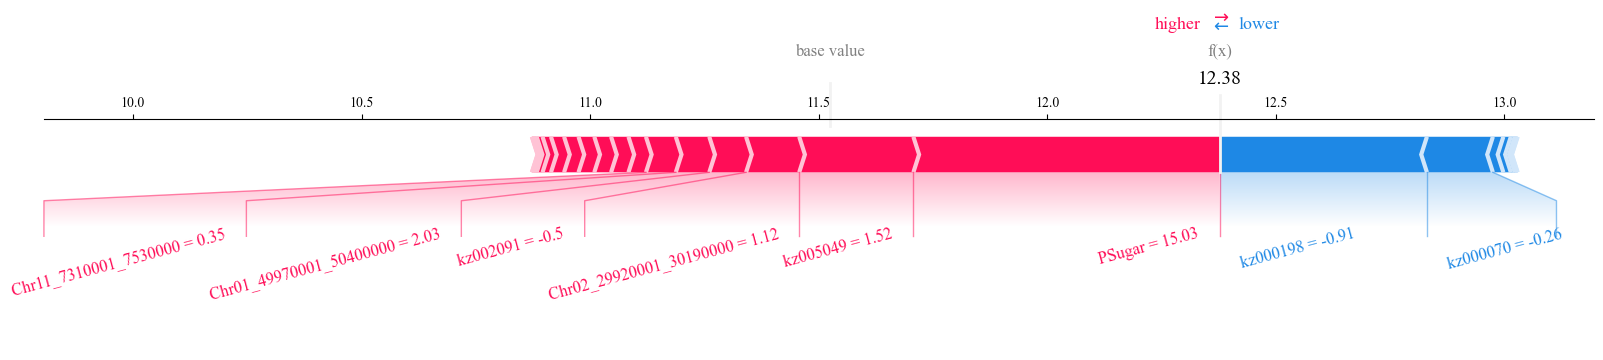

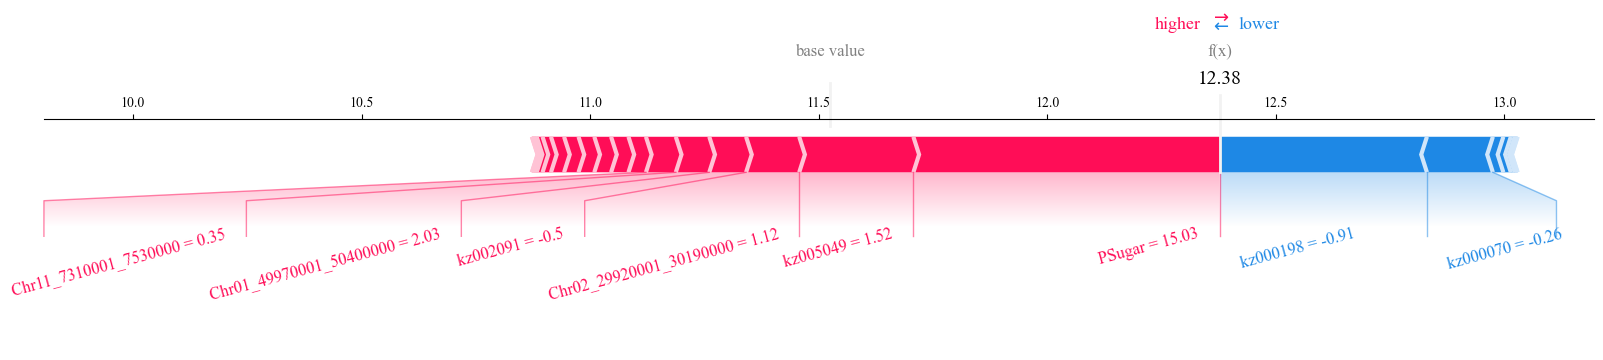

In [10]:
need_plot_num, need_plot_name = 294, "D554"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = True)
    #plt.savefig(os.path.join(FIG_PATH, "fig_7_{}_force_plot.pdf".format(need_plot_name)),  format="pdf", dpi=1000, bbox_inches="tight", transparent=True)

In [5]:
target_df[target_df["Type"]=="G"].sort_values(by="HZ-PStarch")

,index,HZ-PStarch,Type
225,D667,6.459861,G
183,D462,7.159134,G
26,D605,7.264884,G
241,D647,7.616179,G
177,D646,8.095238,G
149,D575,8.165678,G
278,D392,8.339943,G
125,D380,8.345457,G
232,D685,8.415687,G
107,D632,8.482408,G


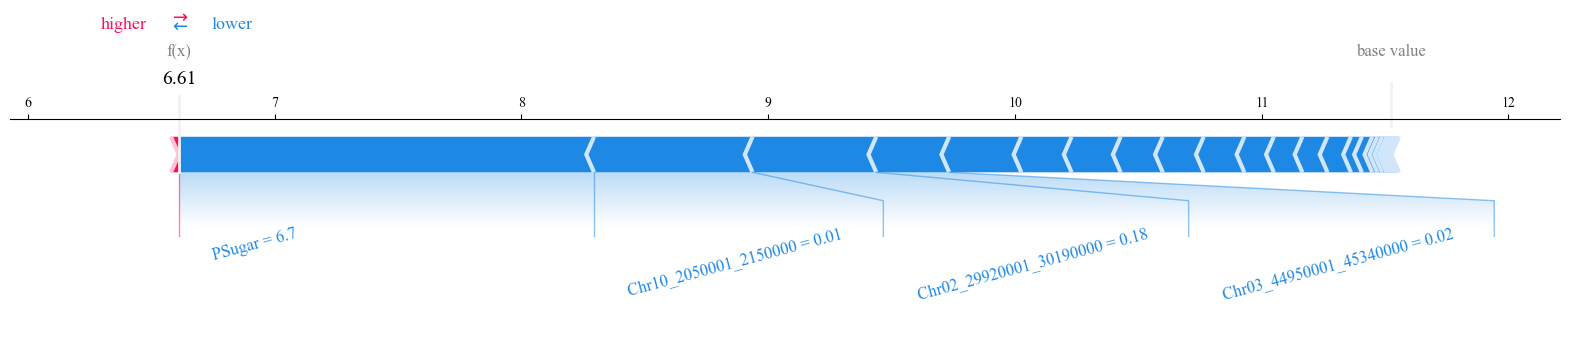

In [6]:
need_plot_num, need_plot_name = 225, "D667"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = True)
    #plt.savefig(os.path.join(FIG_PATH, "fig_4a_young_disease_1.pdf"),  format="pdf", dpi=1000, bbox_inches="tight")

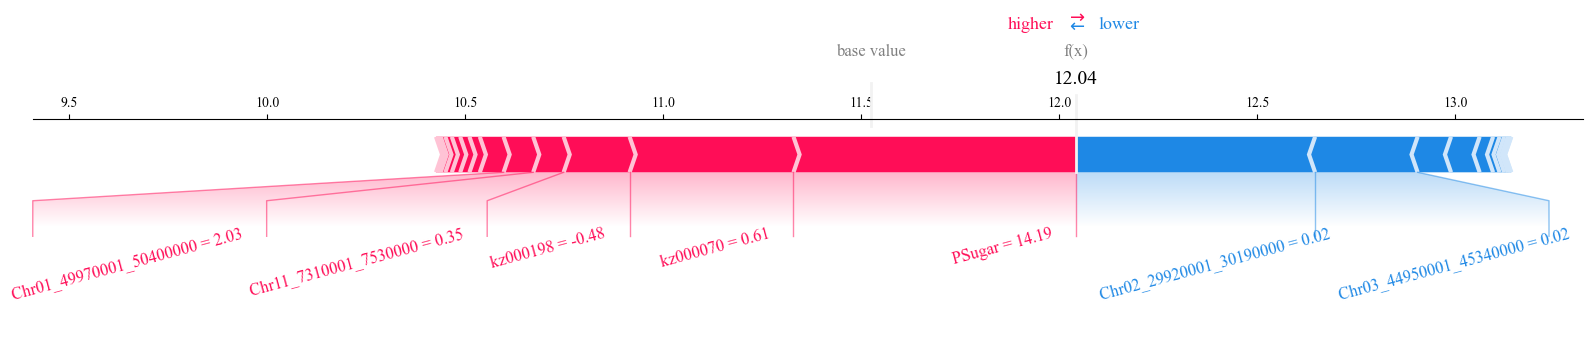

In [7]:
need_plot_num, need_plot_name = 187, "D623"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = True)
    #plt.savefig(os.path.join(FIG_PATH, "fig_4a_young_disease_1.pdf"),  format="pdf", dpi=1000, bbox_inches="tight")

In [8]:
target_df[target_df["Type"]=="VC"].sort_values(by="HZ-PStarch")

,index,HZ-PStarch,Type
36,D488,8.009957,VC
168,D412,8.940539,VC
229,D591,9.140726,VC
283,D526,9.404987,VC
121,D653,9.739545,VC
...,...,...,...
50,D518,14.543051,VC
204,D478,14.801568,VC
20,D429,14.857482,VC
181,D472,14.975583,VC


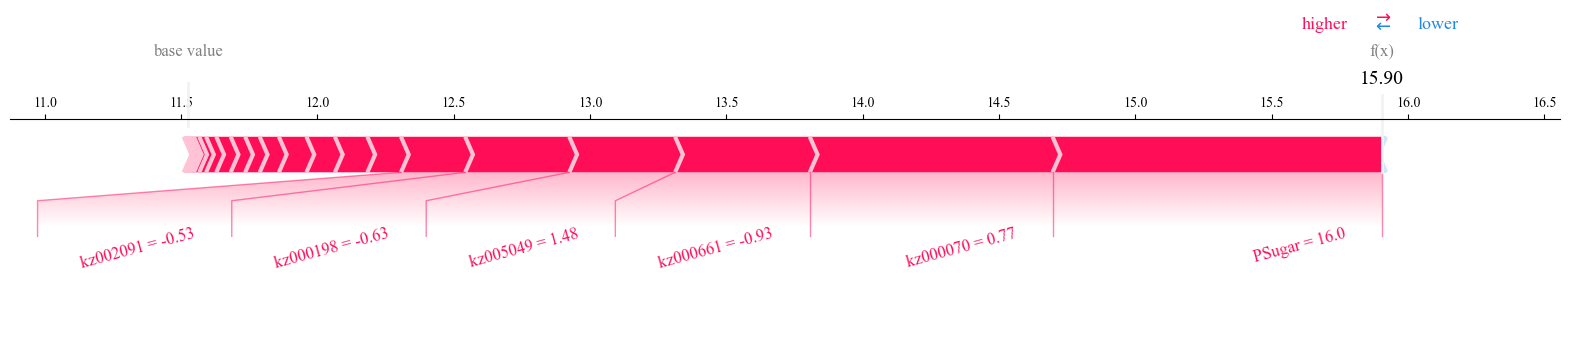

In [9]:
need_plot_num, need_plot_name = 1, "D406"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = True)
    #plt.savefig(os.path.join(FIG_PATH, "fig_4a_young_disease_1.pdf"),  format="pdf", dpi=1000, bbox_inches="tight")

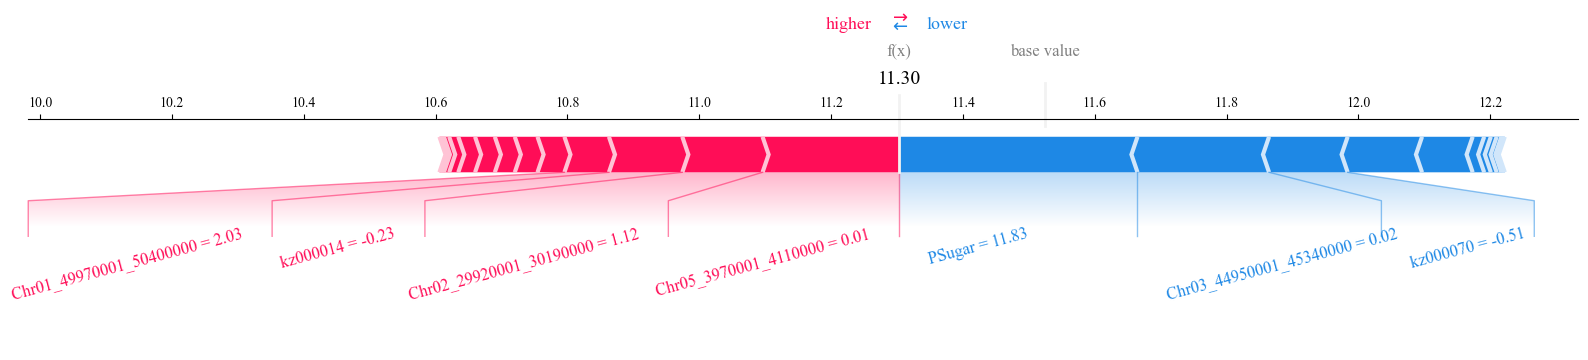

In [10]:
need_plot_num, need_plot_name = 36, "D488"

with plt.rc_context():
    shap.force_plot(explainer.expected_value,
                    shap_values[:, feat_col].values[need_plot_num],
                    raw_data[feat_col].round(2).loc[need_plot_name, feat_col].values,
                    feat_col,text_rotation=15,
                    matplotlib=True, show = True)
    #plt.savefig(os.path.join(FIG_PATH, "fig_4a_young_disease_1.pdf"),  format="pdf", dpi=1000, bbox_inches="tight")